In [1]:
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# ==========================================
# ⚙️ CONFIGURATION (ปรับจูนตรงนี้)
# ==========================================

# Path ของไฟล์ (แก้ให้ตรงกับเครื่องที่คุณรัน Notebook)
# ถ้า Run บนเครื่องตัวเอง (Windows) ให้แก้ Path เป็น C:/...
TRAFFY_PATH = "../Data/clean/bankok_traffy_clean.csv" 
CONDO_DIR = "../Data/clean"
OUTPUT_DIR = "../Data/score"

RADIUS_KM = 1.5           # รัศมีรอบคอนโดที่จะนำมาคิด (km)

In [3]:
# Load Traffy Data
if os.path.exists(TRAFFY_PATH):
    df_traffy_all = pd.read_csv(TRAFFY_PATH)
    
    # Clean Coordinates
    df_traffy_all = df_traffy_all.dropna(subset=['lat', 'lon'])
    df_traffy_all['lat'] = pd.to_numeric(df_traffy_all['lat'], errors='coerce')
    df_traffy_all['lon'] = pd.to_numeric(df_traffy_all['lon'], errors='coerce')
    
    print(f"✅ Loaded Traffy Data: {len(df_traffy_all):,} rows")
    display(df_traffy_all.head(3))
else:
    print(f"❌ File not found: {TRAFFY_PATH}")

✅ Loaded Traffy Data: 670,569 rows


,ticket_id,type,organization,comment,photo,photo_after,coords,address,subdistrict,district,province,timestamp,state,star,count_reopen,last_activity,lon,lat
0,2021-CGPMUN,"{น้ำท่วม,ร้องเรียน}","เขตประเวศ,ฝ่ายโยธา เขตประเวศ",น้ำท่วมเวลาฝนตกและทะลุเข้าบ้านเดือดร้อนมากทุกๆ...,https://storage.googleapis.com/traffy_public_b...,https://storage.googleapis.com/traffy_public_b...,"100.66709,13.67891",189 เฉลิมพระเกียรติ ร.9 แขวง หนองบอน เขต ประเว...,หนองบอน,ประเวศ,กรุงเทพมหานคร,2021-09-19 14:56:08.924992+00,เสร็จสิ้น,4.0,0,2022-06-21 08:21:09.532782+00,100.66709,13.67891
1,2021-7XATFA,{สะพาน},เขตสาทร,สะพานลอยปรับปรุงไม่เสร็จตามกำหนด\nปากซอย สาทร12,https://storage.googleapis.com/traffy_public_b...,NaN,"100.52649,13.72060",191/1 ถนน สาทรเหนือ แขวง สีลม เขตบางรัก กรุงเท...,ยานนาวา,สาทร,กรุงเทพมหานคร,2021-09-26 05:03:52.594898+00,เสร็จสิ้น,NaN,0,2022-06-06 01:17:12.272904+00,100.52649,13.72060
2,2021-DVEWYM,"{น้ำท่วม,ถนน}","เขตลาดพร้าว,ฝ่ายโยธา เขตลาดพร้าว",ซอยลาดพร้าววังหิน 75 ถนนลาดพร้าววังหิน แขวงลาด...,https://storage.googleapis.com/traffy_public_b...,NaN,"100.59165,13.82280",702 ถ. ลาดพร้าววังหิน แขวงลาดพร้าว เขตลาดพร้าว...,ลาดพร้าว,ลาดพร้าว,กรุงเทพมหานคร,2021-12-09 12:29:08.408763+00,เสร็จสิ้น,5.0,0,2022-08-12 07:18:44.884945+00,100.59165,13.82280


In [4]:
def haversine_vectorized(lat1, lon1, lat2, lon2):
    """
    คำนวณระยะทาง (km) ระหว่างจุด 1 จุด (lat1) กับ หลายจุด (lat2 array)
    """
    R = 6371  # รัศมีโลก (km)
    
    # แปลง Degree -> Radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    
    return R * c

In [5]:
def calculate_raw_issue_count_vectorized(condo_lat, condo_lon, traffy_df):
    """
    ฟังก์ชันสำหรับคำนวณจำนวนประเด็น (Issue Count) ดิบๆ
    ในรัศมีรอบคอนโด โดยไม่ใช้การถ่วงน้ำหนัก (Weighting)
    """
    
    if traffy_df.empty:
        # หากไม่มีข้อมูล Traffy เลย ให้นับเป็น 0
        return 0

    # 1. คำนวณระยะทางทั้งหมดรวดเดียว (สมมติว่า haversine_vectorized ถูกกำหนดไว้แล้ว)
    # *** คุณต้องแน่ใจว่าได้ import หรือกำหนด haversine_vectorized ไว้แล้ว ***
    dists = haversine_vectorized(condo_lat, condo_lon, traffy_df['lat'].values, traffy_df['lon'].values)
    
    # 2. กรองเฉพาะที่อยู่ในรัศมี (Filter Mask)
    mask = dists <= RADIUS_KM
    
    # 3. นับจำนวนประเด็น
    # Count = จำนวนของ True ใน mask
    raw_issue_count = np.sum(mask)
    
    return int(raw_issue_count)

In [6]:
# หาไฟล์
condo_files = glob.glob(os.path.join(CONDO_DIR, "condo_*_clean.csv"))
os.makedirs(OUTPUT_DIR, exist_ok=True)
all_scored_data = []

print(f"🚀 Start Scoring for {len(condo_files)} districts...\n")

for file_path in condo_files:
    district_name = os.path.basename(file_path).replace("condo_", "").replace("_clean.csv", "")
    print(f"📍 Processing: {district_name}")
    
    # 1. Load Condo Data
    df_condo = pd.read_csv(file_path)
    
    # 2. Filter Traffy
    df_traffy_local = df_traffy_all[df_traffy_all['district'].astype(str).str.contains(district_name, na=False)]
    
    if df_traffy_local.empty:
        # ไม่มีข้อมูล Traffy เลย -> Raw = 0 -> Normalized = 1.0
        df_condo['issue_count'] = 0
    else:
        # 3. คำนวณ Raw Score (ค่าติดลบ)
        # เรียกใช้ฟังก์ชันใหม่ calculate_raw_negative_score
        raw_scores = df_condo.apply(
            lambda row: calculate_raw_issue_count_vectorized(row['latitude'], row['longitude'], df_traffy_local), 
            axis=1
        )
        df_condo['issue_count'] = raw_scores
        
    # 5. Save & Collect
    output_path = os.path.join(OUTPUT_DIR, f"condo_{district_name}_scored.csv")
    df_condo.to_csv(output_path, index=False, encoding='utf-8-sig')
    
    all_scored_data.append(df_condo)

print("\n✅ All Done! Files saved to:", OUTPUT_DIR)

# --- ตรวจสอบผลลัพธ์ ---
if all_scored_data:
    df_check = pd.concat(all_scored_data)

🚀 Start Scoring for 8 districts...

📍 Processing: คลองเตย
📍 Processing: จตุจักร
📍 Processing: บางกะปิ
📍 Processing: บางเขน
📍 Processing: บางแค
📍 Processing: ปทุมวัน
📍 Processing: ประเวศ
📍 Processing: วัฒนา

✅ All Done! Files saved to: ../Data/score


In [10]:
df_check.sort_values(by='issue_count', ascending=False)

,Project_Name,condo_name,Price,Room_Type,Floor,Bedrooms,Bathrooms,Room_Size,Original_Link,district_name,latitude,longitude,issue_count
143,คอนโด 2-ห้องนอน ที่ เลิศอุบล สกายไลฟ์ ทาวเวอร์...,LERT UBON SKY LIFE TOWER,7200000.0,2 ห้องนอน,NaN,2 ห้องนอน,2 ห้องน้ำ,94 ตร.ม.,https://propertyhub.in.th/listings/%E0%B8%84%E...,เขตจตุจักร,13.809904,100.563856,13143
14,คอนโด 3-ห้องนอน ที่ เดอะ เรสซิเดนเซส แอท เซนต์...,The Residences at The St. Regis Bangkok,140000000.0,3 ห้องนอน,NaN,3 ห้องนอน,4 ห้องน้ำ,458 ตร.ม.,https://propertyhub.in.th/listings/%E0%B8%84%E...,เขตปทุมวัน,13.738997,100.539573,12533
189,1 Bedroom 1 Bathroom 33.5 Sq.m Privacy jatujak,The Privacy Jatujak,5190000.0,1 ห้องนอน,31,1 ห้องนอน,1 ห้องน้ำ,33.5 ตร.ม.,https://propertyhub.in.th/listings/1-bedroom-1...,เขตจตุจักร,13.810157,100.560132,12423
65,ขายคอนโด เดอะไพรเวซี่ จตุจักร อาคาร 1 ชั้น 19 ...,The Privacy Jatujak,3490000.0,1 ห้องนอน,19,1 ห้องนอน,1 ห้องน้ำ,27 ตร.ม.,https://propertyhub.in.th/listings/%E0%B8%82%E...,เขตจตุจักร,13.810157,100.560132,12423
211,2 Bed 1 Bath 45.5 SQ.M The Privacy Jatujak,The Privacy Jatujak,5790000.0,2 ห้องนอน,29,2 ห้องนอน,1 ห้องน้ำ,45.5 ตร.ม.,https://propertyhub.in.th/listings/2-bed-1-bat...,เขตจตุจักร,13.810157,100.560132,12423
...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,ขายคอนโด ( ขายต่ำกว่าตลาด ) Nothing Hill phah...,Notting Hill Phahol - Kaset,2800000.0,2 ห้องนอน,6,2 ห้องนอน,1 ห้องน้ำ,38 ตร.ม.,https://propertyhub.in.th/listings/%E0%B8%82%E...,เขตบางเขน,13.859999,100.587101,882
151,คอนโดต้องการขาย น็อตติ้ง ฮิลล์ พหล-เกษตร พหล...,Notting Hill Phahol - Kaset,3500000.0,2 ห้องนอน,4,2 ห้องนอน,1 ห้องน้ำ,35 ตร.ม.,https://propertyhub.in.th/listings/%E0%B8%84%E...,เขตบางเขน,13.859999,100.587101,882
152,คอนโดต้องการขาย ห้องเปล่า น็อตติ้ง ฮิลล์ พหล-เ...,Notting Hill Phahol - Kaset,3100000.0,1 ห้องนอน,6,2 ห้องนอน,1 ห้องน้ำ,35 ตร.ม.,https://propertyhub.in.th/listings/%E0%B8%84%E...,เขตบางเขน,13.859999,100.587101,882
105,🔴SV2349🟡 ขายถูกมาก👍 Notting Hill Phahol - Kase...,Notting Hill Phahol - Kaset,2990000.0,1 ห้องนอน,3,1 ห้องนอน,1 ห้องน้ำ,35 ตร.ม.,https://propertyhub.in.th/listings/sv2349-%E0%...,เขตบางเขน,13.859999,100.587101,882


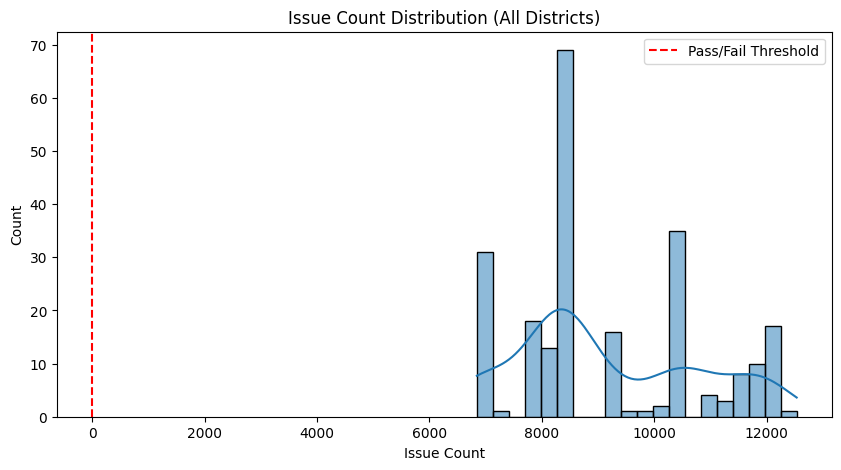

In [8]:
# รวมข้อมูลทุกเขตมาดูภาพรวม
if all_scored_data:
    df_final = pd.concat(all_scored_data, ignore_index=True)

    # 1. ดู Distribution ของคะแนน
    plt.figure(figsize=(10, 5))
    sns.histplot(df_final.loc[df_final['district_name'] == 'เขตปทุมวัน', ['issue_count']], bins=20, kde=True, color='green')
    plt.title('Issue Count Distribution (All Districts)')
    plt.xlabel('Issue Count')
    plt.axvline(x=0.5, color='red', linestyle='--', label='Pass/Fail Threshold')
    plt.legend()
    plt.show()

In [11]:
df_final.head()

,Project_Name,condo_name,Price,Room_Type,Floor,Bedrooms,Bathrooms,Room_Size,Original_Link,district_name,latitude,longitude,issue_count
0,คอนโด 3-ห้องนอน ที่ ไซมิส เอ๊กซ์คลูซีพ 42 ใกล้...,Siamese Exclusive Sukhumvit 42,15000000.0,3 ห้องนอน,23,3 ห้องนอน,2 ห้องน้ำ,71.5 ตร.ม.,https://propertyhub.in.th/listings/%E0%B8%84%E...,เขตคลองเตย,13.716817,100.585396,6142
1,คอนโด 3-ห้องนอน ที่ มะฮอกกานี ทาวเวอร์ คอนโดมิ...,Mahogany Tower,44000000.0,3 ห้องนอน,21,3 ห้องนอน,3 ห้องน้ำ,308 ตร.ม.,https://propertyhub.in.th/listings/%E0%B8%84%E...,เขตคลองเตย,13.722536,100.566463,10838
2,ขาย ไลฟ์ สุขุมวิท 48 ราคาถูก ต้องขาย ! ตกแต่งส...,Life Sukhumvit 48,4880000.0,2 ห้องนอน,28,2 ห้องนอน,1 ห้องน้ำ,49 ตร.ม.,https://propertyhub.in.th/listings/%E0%B8%82%E...,เขตคลองเตย,13.711304,100.594735,5476
3,คอนโด 1-ห้องนอน ที่ เดอะ ลุมพินี 24 ใกล้ BTS พ...,The Lumpini 24,4500000.0,1 ห้องนอน,17,1 ห้องนอน,1 ห้องน้ำ,26.22 ตร.ม.,https://propertyhub.in.th/listings/%E0%B8%84%E...,เขตคลองเตย,13.722846,100.566175,10905
4,คอนโด 2-ห้องนอน ที่ บ้าน สุขุมวิท ใกล้ BTS ทอง...,Baan Sukhumvit,6000000.0,2 ห้องนอน,7,2 ห้องนอน,1 ห้องน้ำ,77.5 ตร.ม.,https://propertyhub.in.th/listings/%E0%B8%84%E...,เขตคลองเตย,13.719031,100.573671,8850


In [16]:
df_final['Room_Size_clean'] = df_final['Room_Size'].str.replace(' ตร.ม.', '', regex=False).astype(float)
df_encoded = pd.get_dummies(df_final, columns=['district_name'], drop_first=True)
df_encoded = df_encoded.dropna()
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1671 entries, 0 to 1764
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Project_Name              1671 non-null   object 
 1   condo_name                1671 non-null   object 
 2   Price                     1671 non-null   float64
 3   Room_Type                 1671 non-null   object 
 4   Floor                     1671 non-null   object 
 5   Bedrooms                  1671 non-null   object 
 6   Bathrooms                 1671 non-null   object 
 7   Room_Size                 1671 non-null   object 
 8   Original_Link             1671 non-null   object 
 9   latitude                  1671 non-null   float64
 10  longitude                 1671 non-null   float64
 11  issue_count               1671 non-null   int64  
 12  Room_Size_clean           1671 non-null   float64
 13  district_name_เขตจตุจักร  1671 non-null   bool   
 14  district_name

In [33]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import pandas as pd
# Assuming df is your cleaned DataFrame with numerical features selected

# 1. Feature Selection
features = ['Price', 'Room_Size_clean', 'issue_count', 'latitude', 'longitude']
X = df_encoded[features]

# 2. Setup Pipeline (Scaling + Clustering)
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('kmeans', KMeans(n_clusters=8, random_state=42, n_init=10)) # Using K=8 as an example
])

# 3. Fit and Predict
pipeline.fit(X)
df_encoded['cluster_label'] = pipeline.named_steps['kmeans'].labels_

# 4. Analyze Results
cluster_summary = df_encoded.groupby('cluster_label')[features].mean()
print(cluster_summary)

                      Price  Room_Size_clean  issue_count   latitude  \
cluster_label                                                          
0              1.484749e+07        66.372698  8473.250000  13.738134   
1              2.779103e+06        36.917321  3264.497890  13.721651   
2              2.060491e+06        31.568424  4712.817734  13.709977   
3              8.585743e+07       250.715714  9442.714286  13.735801   
4              2.335717e+06        31.826271  3618.316384  13.869571   
5              6.073482e+06        40.633986  9449.858696  13.805471   
6              5.500000e+08       756.600000  6884.000000  13.723832   
7              1.250000e+08      1500.000000  5792.000000  13.795550   

                longitude  
cluster_label              
0              100.570520  
1              100.633818  
2              100.405565  
3              100.555803  
4              100.615242  
5              100.557372  
6              100.578480  
7              100.558168  

In [30]:
df_encoded

,Project_Name,condo_name,Price,Room_Type,Floor,Bedrooms,Bathrooms,Room_Size,Original_Link,latitude,...,issue_count,Room_Size_clean,district_name_เขตจตุจักร,district_name_เขตบางกะปิ,district_name_เขตบางเขน,district_name_เขตบางแค,district_name_เขตปทุมวัน,district_name_เขตประเวศ,district_name_เขตวัฒนา,cluster_label
0,คอนโด 3-ห้องนอน ที่ ไซมิส เอ๊กซ์คลูซีพ 42 ใกล้...,Siamese Exclusive Sukhumvit 42,15000000.0,3 ห้องนอน,23,3 ห้องนอน,2 ห้องน้ำ,71.5 ตร.ม.,https://propertyhub.in.th/listings/%E0%B8%84%E...,13.716817,...,6142,71.50,False,False,False,False,False,False,False,2
1,คอนโด 3-ห้องนอน ที่ มะฮอกกานี ทาวเวอร์ คอนโดมิ...,Mahogany Tower,44000000.0,3 ห้องนอน,21,3 ห้องนอน,3 ห้องน้ำ,308 ตร.ม.,https://propertyhub.in.th/listings/%E0%B8%84%E...,13.722536,...,10838,308.00,False,False,False,False,False,False,False,2
2,ขาย ไลฟ์ สุขุมวิท 48 ราคาถูก ต้องขาย ! ตกแต่งส...,Life Sukhumvit 48,4880000.0,2 ห้องนอน,28,2 ห้องนอน,1 ห้องน้ำ,49 ตร.ม.,https://propertyhub.in.th/listings/%E0%B8%82%E...,13.711304,...,5476,49.00,False,False,False,False,False,False,False,0
3,คอนโด 1-ห้องนอน ที่ เดอะ ลุมพินี 24 ใกล้ BTS พ...,The Lumpini 24,4500000.0,1 ห้องนอน,17,1 ห้องนอน,1 ห้องน้ำ,26.22 ตร.ม.,https://propertyhub.in.th/listings/%E0%B8%84%E...,13.722846,...,10905,26.22,False,False,False,False,False,False,False,2
4,คอนโด 2-ห้องนอน ที่ บ้าน สุขุมวิท ใกล้ BTS ทอง...,Baan Sukhumvit,6000000.0,2 ห้องนอน,7,2 ห้องนอน,1 ห้องน้ำ,77.5 ตร.ม.,https://propertyhub.in.th/listings/%E0%B8%84%E...,13.719031,...,8850,77.50,False,False,False,False,False,False,False,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1760,คอนโด 2-ห้องนอน ที่ วาลเด้น สุขุมวิท 39 ใกล้ B...,Walden Sukhumvit 39,17207365.0,2 ห้องนอน,8,2 ห้องนอน,2 ห้องน้ำ,88.11 ตร.ม.,https://propertyhub.in.th/listings/%E0%B8%84%E...,13.733041,...,7770,88.11,False,False,False,False,False,False,True,2
1761,คอนโด 2-ห้องนอน ที่ แวร์เด สุขุมวิท 49/15 ใกล้...,Verde Sukhumvit 49/15,15575000.0,2 ห้องนอน,6,2 ห้องนอน,2 ห้องน้ำ,78 ตร.ม.,https://propertyhub.in.th/listings/%E0%B8%84%E...,13.741719,...,7393,78.00,False,False,False,False,False,False,True,2
1762,คอนโด 1-ห้องนอน ที่ เอ็กซ์ที เอกมัย ใกล้ BTS ท...,XT EKKAMAI,7950000.0,1 ห้องนอน,30,1 ห้องนอน,1 ห้องน้ำ,30.5 ตร.ม.,https://propertyhub.in.th/listings/%E0%B8%84%E...,13.733798,...,7295,30.50,False,False,False,False,False,False,True,2
1763,คอนโด 1-ห้องนอน ที่ แชปเตอร์ ทองหล่อ 25 ใกล้ ท...,Chapter Thonglor 25,7300000.0,1 ห้องนอน,7,1 ห้องนอน,1 ห้องน้ำ,42 ตร.ม.,https://propertyhub.in.th/listings/%E0%B8%84%E...,13.742850,...,4696,42.00,False,False,False,False,False,False,True,0


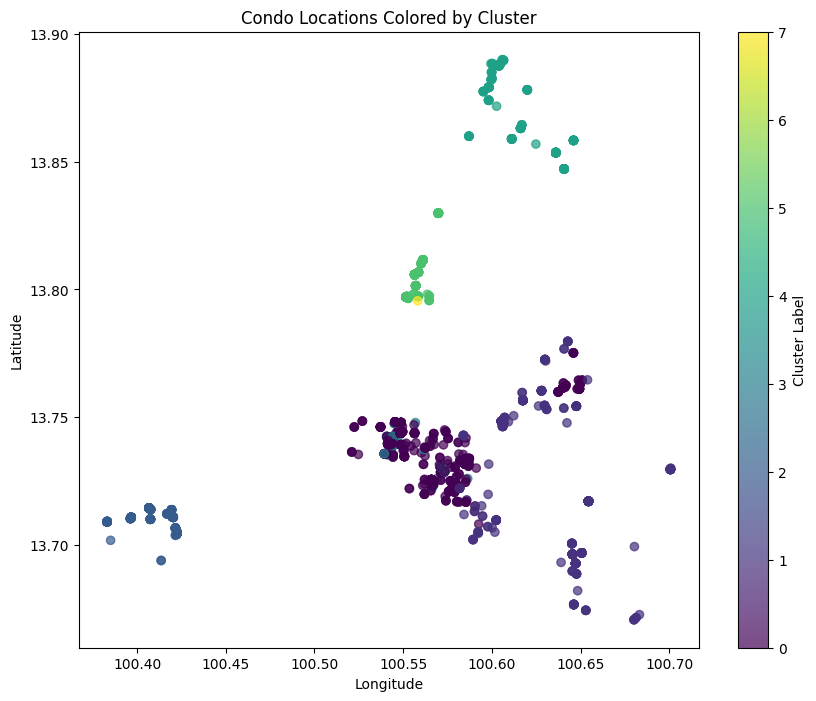

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    df_encoded['longitude'],
    df_encoded['latitude'],
    c=df_encoded['cluster_label'],
    alpha=0.7
)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Condo Locations Colored by Cluster')
plt.colorbar(scatter, label='Cluster Label')
plt.show()

<Figure size 1200x1000 with 0 Axes>

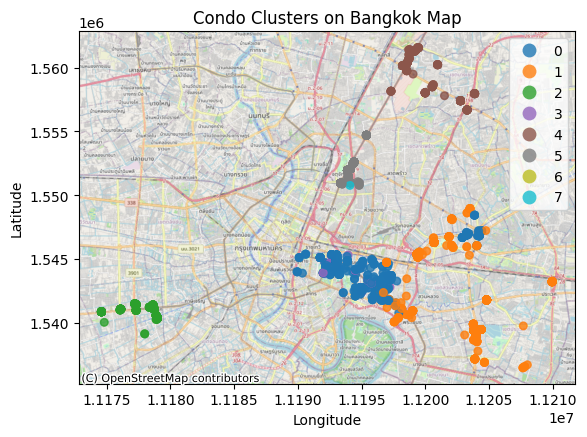

In [34]:
# ...existing code...
import geopandas as gpd
import contextily as ctx

gdf = gpd.GeoDataFrame(
    df_encoded,
    geometry=gpd.points_from_xy(df_encoded['longitude'], df_encoded['latitude']),
    crs="EPSG:4326",
)
gdf = gdf.to_crs(epsg=3857)

plt.figure(figsize=(12, 10))
ax = gdf.plot(
    ax=None,
    column='cluster_label',
    categorical=True,
    legend=True,
    alpha=0.8,
    markersize=30,
)

# use Stamen if available, otherwise fall back to OpenStreetMap
try:
    basemap = ctx.providers.Stamen.TonerLite
except Exception:
    basemap = ctx.providers.OpenStreetMap.Mapnik

ctx.add_basemap(ax, source=basemap)
plt.title('Condo Clusters on Bangkok Map')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()
# ...existing code...